## 函数

### 基本信息、基本函数

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,ttest_ind,ttest_rel,pearsonr,spearmanr,wilcoxon
import statsmodels.formula.api as smf

sns.set(font_scale=1.5,style="white")
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [7]:
RSNs = ['Vis','SomMot','DorsAttn','SalVentAttn','Limbic','Cont','Default']
ICNs = RSNs+['Sub']

bold_path = '/data/dy/TIS_MDD/BOLD'
Event_mask_path = '/data/dy/TIS_MDD/HAC/Event_mask'
sub_ls = os.listdir(bold_path)
print(f"被试人数：{len(sub_ls)}")

被试人数：31


In [3]:
import statsmodels.api as sm
def BH_correct(p_values):
    p_values = np.array(p_values)
    return sm.stats.multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

In [4]:
demo_info = pd.read_csv('/data/dy/TIS_MDD/demo_info.csv',index_col=0)
demo_info['sub_id'] = demo_info.index
demo_info['sex_id'] = [1 if i=='M' else 0 for i in demo_info['sex']]

def fun_add_demo_time(data,run_label):
    data = pd.concat([data,demo_info],axis=1)
    data['time'] = [run_label for i in range(data.shape[0])]
    data = data.dropna(axis=0)
    return data

def fun_concat(data1,data2):
    common_index = data1.index.intersection(data2.index)
    data = pd.concat([data1.loc[common_index,:],data2.loc[common_index,:]])
    return data

In [5]:
def fill_nan(df):
    # 确保列名是整数类型
    df.columns = range(df.shape[1])
    nan_locations = df.isna().stack()[df.isna().stack()].index.tolist()
    for loc in nan_locations:
        row, col = loc
        if col == 0:  # 最左列
            df.iloc[row, col] = np.nanmean(df.iloc[row, col+1:col+3])
        elif col == df.shape[1] - 1:  # 最右列
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-2:col])
        else:  # 其他位置
            df.iloc[row, col] = np.nanmean(df.iloc[row, col-1:col+2])
    
    # 恢复原始列名
    df.columns = df.columns.astype(str)
    return df

def check_df(df):
    # 保存原始列名
    cols = df.columns
    df = fill_nan(df)
    df.columns = cols
    return df
    
def read_bold(sub,run_label):
    bold_ctx = pd.read_csv(os.path.join(bold_path,sub,run_label,schaefer+'.csv'))
    bold_sub = pd.read_csv(os.path.join(bold_path,sub,run_label,'hcp.csv'))
    bold = pd.concat([bold_ctx,bold_sub],axis=1)
    bold = check_df(bold)
    return bold

### rs-FC 函数

In [11]:
def get_rsFC(run_label):
    result = []
    sub_id = []
    for sub in sub_ls:
        path_ = os.path.join(Event_mask_path,sub,run_label)
        if(len(os.listdir(path_))!=0):
            bold = read_bold(sub,run_label);fc = np.corrcoef(bold.T)
            result.append(fc)
            sub_id.append(sub)
    return np.array(result),np.array(sub_id)

def get_rsFC_xyrois(run_label,x_rois,y_rois):
    arr,id_sub = get_rsFC(run_label)
    result = []
    for i in range(arr.shape[0]):
        fc = pd.DataFrame(arr[i],columns=roi_ls,index=roi_ls)
        result.append(np.array(fc.loc[x_rois,y_rois]))
    result = np.array(result)
    return pd.DataFrame(np.array([np.mean(result[i]) for i in range(result.shape[0])]),columns=['FC'],index=id_sub)

def regress_out(df,y_ls,x_ls):
    Y = np.array(df.loc[:,y_ls]);x = np.array(df.loc[:,x_ls])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]

    return pd.DataFrame(Y_resid,index=df.index,columns=y_ls)

def fun_rsn_FC(x_rsn,time2):
    x_rois = atlas[atlas['ICN']==x_rsn]['Name'].tolist() if x_rsn!='Sub' else roi_ls[-19:]
    p_s = pd.DataFrame(np.zeros([len(ICNs),2]),columns=['sta','p'],index=ICNs)
    dfs = pd.DataFrame([])
    for rsn in ICNs:
        y_rois = roi_ls[-19:] if rsn=='Sub' else atlas[atlas['ICN']==rsn]['Name'].tolist()
        ## 第一个时间
        xyFC1 = get_rsFC_xyrois('baseline',x_rois,y_rois)
        xyFC1 = fun_add_demo_time(xyFC1,'baseline')
        ## 第二个时间
        xyFC2 = get_rsFC_xyrois(time2,x_rois,y_rois)
        xyFC2 = fun_add_demo_time(xyFC2,time2)
        ## 合并、输出
        xyFC = fun_concat(xyFC1,xyFC2)
        model = smf.mixedlm("FC ~ time + sex_id + age", data=xyFC, groups="sub_id")
        result = model.fit()
        t = result.tvalues[1];p = result.pvalues[1]
        p_s.loc[rsn,['sta','p']]=[t,p]
        xyFC['rsn_x'] = [x_rsn for _ in xyFC.index];xyFC['rsn_y'] = [rsn for _ in xyFC.index];
        dfs = pd.concat([dfs,xyFC])
    p_s['q'] = BH_correct(p_s['p'])
    p_s['time'] = [time2 for _ in p_s.index]
    return p_s,dfs

def fun_rsFC_change(x_rsn):
    p_result =  pd.DataFrame([]);fc_result = pd.DataFrame([])
    for time2 in ['5th_201','5th_301','5th_after','4weeks']:
        p_s,xyFC = fun_rsn_FC(x_rsn,time2)
        fc_result = pd.concat([fc_result,xyFC])
        p_result = pd.concat([p_result,p_s])
    return p_result,fc_result

### 量表

In [12]:
def fun_match_scale(scale,timepoint):
    result = pd.DataFrame([])
    df = scale.copy()
    process = df[df['condition'] == timepoint]
    for sub in sub_ls:
        if(sub in process.index):
            result = pd.concat([result,process.loc[sub,:]],axis=1)
    return result.T

def fun_scale_change(scale,col_name,after_label):
    df = pd.concat([fun_match_scale(scale,'pre')[col_name],fun_match_scale(scale,after_label)[col_name]],axis=1).dropna(axis=0)
    df.columns = ['baseline','!baseline']
    df = pd.DataFrame(df['!baseline']-df['baseline'],columns=['scale'])
    return df

madrs = pd.read_csv('/data/dy/TIS_MDD/Scales/madrs.csv',index_col='sub') ## MADRS_all
gad7 = pd.read_csv('/data/dy/TIS_MDD/Scales/gad7.csv',index_col='sub') ## GAD7_ALL
hama = pd.read_csv('/data/dy/TIS_MDD/Scales/hama.csv',index_col='sub') ## HAMA_all
hamd = pd.read_csv('/data/dy/TIS_MDD/Scales/hamd.csv',index_col='sub') ## HAMD_all
phq9 = pd.read_csv('/data/dy/TIS_MDD/Scales/phq9.csv',index_col='sub') ## PHQ9_ALL
psqi = pd.read_csv('/data/dy/TIS_MDD/Scales/psqi.csv',index_col='sub') ## PSQI_ALL 只有基线和4周随访
qids = pd.read_csv('/data/dy/TIS_MDD/Scales/qids.csv',index_col='sub') ## QIDS_all
sf36 = pd.read_csv('/data/dy/TIS_MDD/Scales/sf36.csv',index_col='sub') ## SF36_all 只有基线和4周随访
shaps = pd.read_csv('/data/dy/TIS_MDD/Scales/shaps.csv',index_col='sub') ## SHAPS_all 只有基线和4周随访
shaps['condition'] = shaps['target']

scales = {}
scales['MADRS_all'] = madrs;scales['GAD7_ALL']=gad7;scales['HAMA_all']=hama;scales['HAMD_all']=hamd;scales['PHQ9_ALL']=phq9
scales['QIDS_all']=qids

scales_4 = {}
scales_4['MADRS_all'] = madrs;scales_4['GAD7_ALL']=gad7;scales_4['HAMA_all']=hama;scales_4['HAMD_all']=hamd;scales_4['PHQ9_ALL']=phq9
scales_4['QIDS_all']=qids;scales_4['PSQI_ALL']=psqi;scales_4['SF36_all']=sf36;scales_4['SHAPS_all']=shaps

In [13]:
import pingouin as pg
def fun_plot_correlation(xyFC,rsn_x,rsn_y,after_label):

    process_label = '5th_after'if after_label=='5th' else '4weeks'
    file = scales.copy() if after_label=='5th' else scales_4.copy()
    c_line = '#38a8c5' if after_label=='5th' else '#cc79f4'
    label = 'D5-post' if after_label=='5th' else 'W4'
    print(f"---Timepoint:{process_label}---")
    ## 选出rsn_y
    df = xyFC[xyFC['rsn_y']==rsn_y].drop_duplicates()
    ## 两个时间相减
    fc0 = df[df['time']=='baseline'];fc1 = df[df['time']==process_label]
    common_index = fc0.index.intersection(fc1.index)
    fc_change = pd.DataFrame(fc1.loc[common_index,'FC']-fc0.loc[common_index,'FC'])
    for col_name in file.keys():
        scale = file[col_name]
        change = fun_scale_change(scale,col_name,after_label)
        ## 配对量表、demo数据
        df = pd.concat([change,fc_change,demo_info],axis=1).dropna(axis=0)
        df['scale'] = np.array(df['scale']).astype(np.float32)
        ## 偏Pearson相关
        partial_corr = pg.partial_corr(data=df,x="FC",y="scale",covar=["age", "sex_id"],method="pearson" )
        r,p = partial_corr.loc['pearson',['r','p-val']]
        print(f"rou={r:.3f}, p={p:.3f}, {col_name}")
        if(p<=0.05):
            y =np.array(df['scale']).astype(np.float64);x=np.array(df['FC']).astype(np.float64)
            ## 绘图
            plt.figure(figsize=(6,4),dpi=300)
            sns.regplot(x=x, y=y,ci=95, 
                        scatter_kws={"facecolors": "#262626","edgecolor": "#262626","s": 25},
                        line_kws={"color": c_line})
            ## x,y上下界
            x_max = np.max(x);x_min = np.min(x);x_range=x_max-x_min
            y_max = np.max(y);y_min = np.min(y);y_range=y_max-y_min
            ## 插入相关性注释
            y_text = y_min+y_range*.05;x_text = x_max-x_range*.2
            plt.text(x_text,y_text,f"r={r:.3f}\np={p:.3f}",ha='left', va='bottom')
            
            plt.xlim(x_min-x_range*.1,x_max+x_range*.1)
            plt.ylim(y_min-y_range*.05,y_max+y_range*.05)
            
            plt.ylabel(f'Δ{col_name[:-4]} (D0→{label})',fontsize=15);plt.xlabel(f"ΔFC ({rsn_x}-{rsn_y})",fontsize=15)
            plt.yticks(fontsize=12);plt.xticks(fontsize=12)

### 绘图

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context("talk")
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from scipy.stats import ttest_rel,wilcoxon

In [28]:
import ptitprince as pt
import statsmodels.formula.api as smf

def p_star(p):
    if(p>0.05):
        return 'n.s.'
    elif(p>0.01):
        return '*'
    elif(p>0.001):
        return '**'
    else:
        return '***'
def regress_out(df,y_ls,x_ls):
    Y = np.array(df.loc[:,y_ls]);x = np.array(df.loc[:,x_ls])
    x = sm.add_constant(x);model = sm.OLS(Y, x).fit();Y_resid = model.resid + model.params[0]

    return pd.DataFrame(Y_resid,index=df.index,columns=y_ls)

def longitudinal_plot(df,value_col,time_order,
                      subj_col = 'sub',time_col='condition',figsize = (10,6),p_values = [],title=None,
                      value_label=None,display_labels=None,palette=None,regress=False,regress_col=None):
    if(display_labels==None):
        display_labels = time_order
    if(value_label==None):
        value_label = value_col
    if(palette == None):
        palette = sns.color_palette("husl", len(time_order))
    if(regress and regress_col==None):
        regress_col = ['age','sex_id']
    ## 开图
    fig, ax = plt.subplots(figsize=figsize,dpi=300)
    ## 云雨图
    pt.RainCloud(x=time_col, y=value_col, data=df, order=time_order, palette=palette,
                     bw=.2, width_viol=1, width_box=.4, offset=.25,alpha=.75, move=-0.0, ax=ax, orient='v',point_size=4)
    ## 调整边界
    y_max = df[value_col].max()
    y_min = df[value_col].min()
    data_range = y_max - y_min
    step = data_range*.15
    ax.set_ylim(y_min - data_range*0.05,
                y_max + data_range*0.05 + len(time_order)*step)
    ax.set_xlim(-.8,len(time_order)-.7)
    ## 设置标签
    ax.set_xlabel('')
    ax.set_xticklabels(display_labels, fontsize=18)
    ax.set_xticks(range(len(time_order)))
    ax.set_ylabel(value_label,labelpad=10, fontsize=25)
    if(title!=None):
        ax.set_title(title,fontsize=25)
    ## 计算p值
    if(len(p_values) == 0):
        a = df[df['condition']==time_order[0]];a.index=a['sub']
        p_values = np.zeros(len(time_order)-1)
        if(regress):
            formula = f"{value_col} ~ {time_col}"
            for i,col in np.ndenumerate(regress_col):
                formula = f"{formula} + {col}"
        for i in range(1,len(time_order)):
            b = df[df['condition']==time_order[i]];b.index=b['sub']
            valid_index = pd.concat([a,b],axis=1).dropna(axis=0).index.tolist()
            if(regress):
                c = pd.concat([a.loc[valid_index,:],b.loc[valid_index,:]])
                model = smf.mixedlm(formula, data=c, groups=subj_col)
                result = model.fit();p=result.pvalues[1]
            else:
                _,p = ttest_rel(a.loc[valid_index,value_col],b.loc[valid_index,value_col])
            p_values[i-1]=p
    ## 标记显著
    h = data_range * 0.04
    current_y = y_max + data_range*0.05
    for i in range(1,len(time_order)):
        plt.plot([0,0,i,i],[current_y,current_y+h,current_y+h,current_y],lw=1.2, c='k')
        plt.text(i/2, current_y+h, p_star(p_values[i-1]), ha='center', va='bottom', fontsize=15)
        current_y += step
    
    # 同被试连线
    x_pos = {t: i for i, t in enumerate(time_order)}
    for sid, g in df.groupby(subj_col):
        g = g.dropna(subset=[value_col]).sort_values(time_col, key=lambda x: x.map(x_pos))
        if g[time_col].nunique() >= 2:
            xs = [x_pos[t] for t in g[time_col]]
            ys = g[value_col].to_list()
            ax.plot(xs, ys, color='0.7', alpha=0.5, linewidth=1, zorder=1)

In [29]:
import seaborn as sns

palette = sns.color_palette("husl", 5)
hex_colors = [f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for r, g, b in palette]

# 打印每个颜色对应的十六进制代码
for i, hex_color in enumerate(hex_colors):
    print(f"颜色 {i+1}: {hex_color}")

颜色 1: #f67088
颜色 2: #ad9c31
颜色 3: #33b07a
颜色 4: #38a8c5
颜色 5: #cc79f4


## 分析

In [70]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings("ignore", message="Random effects covariance is singular")

In [71]:
schaefer = '100'
n_roi = int(schaefer)+19
roi_ls = read_bold(sub_ls[0],'baseline').columns.tolist()

atlas = pd.read_csv(f"/data/dy/atlas/schaefer{schaefer}x7_MNI.csv")
atlas['Name'] = roi_ls[:-19]

In [72]:
rsn_x = 'Default'
ps,xyFC = fun_rsFC_change(rsn_x)

In [67]:
ps['index'] = ps.index
print(ps[ps['index']=='SalVentAttn'])

                  sta         p         q       time        index
SalVentAttn -1.652992  0.098332  0.196665    5th_201  SalVentAttn
SalVentAttn -4.525861  0.000006  0.000024    5th_301  SalVentAttn
SalVentAttn -2.458923  0.013935  0.027871  5th_after  SalVentAttn
SalVentAttn -1.346224  0.178230  0.591850     4weeks  SalVentAttn


In [68]:
df = pd.DataFrame([])
for rsn in ['Vis','SalVentAttn','DorsAttn','Default']:
    fcs = xyFC[xyFC['rsn_y']==rsn].drop_duplicates()
    df = pd.concat([df,fcs])
df.to_csv(f"/data/dy/TIS_MDD/FC_change/Default_{schaefer}.csv",index=False)

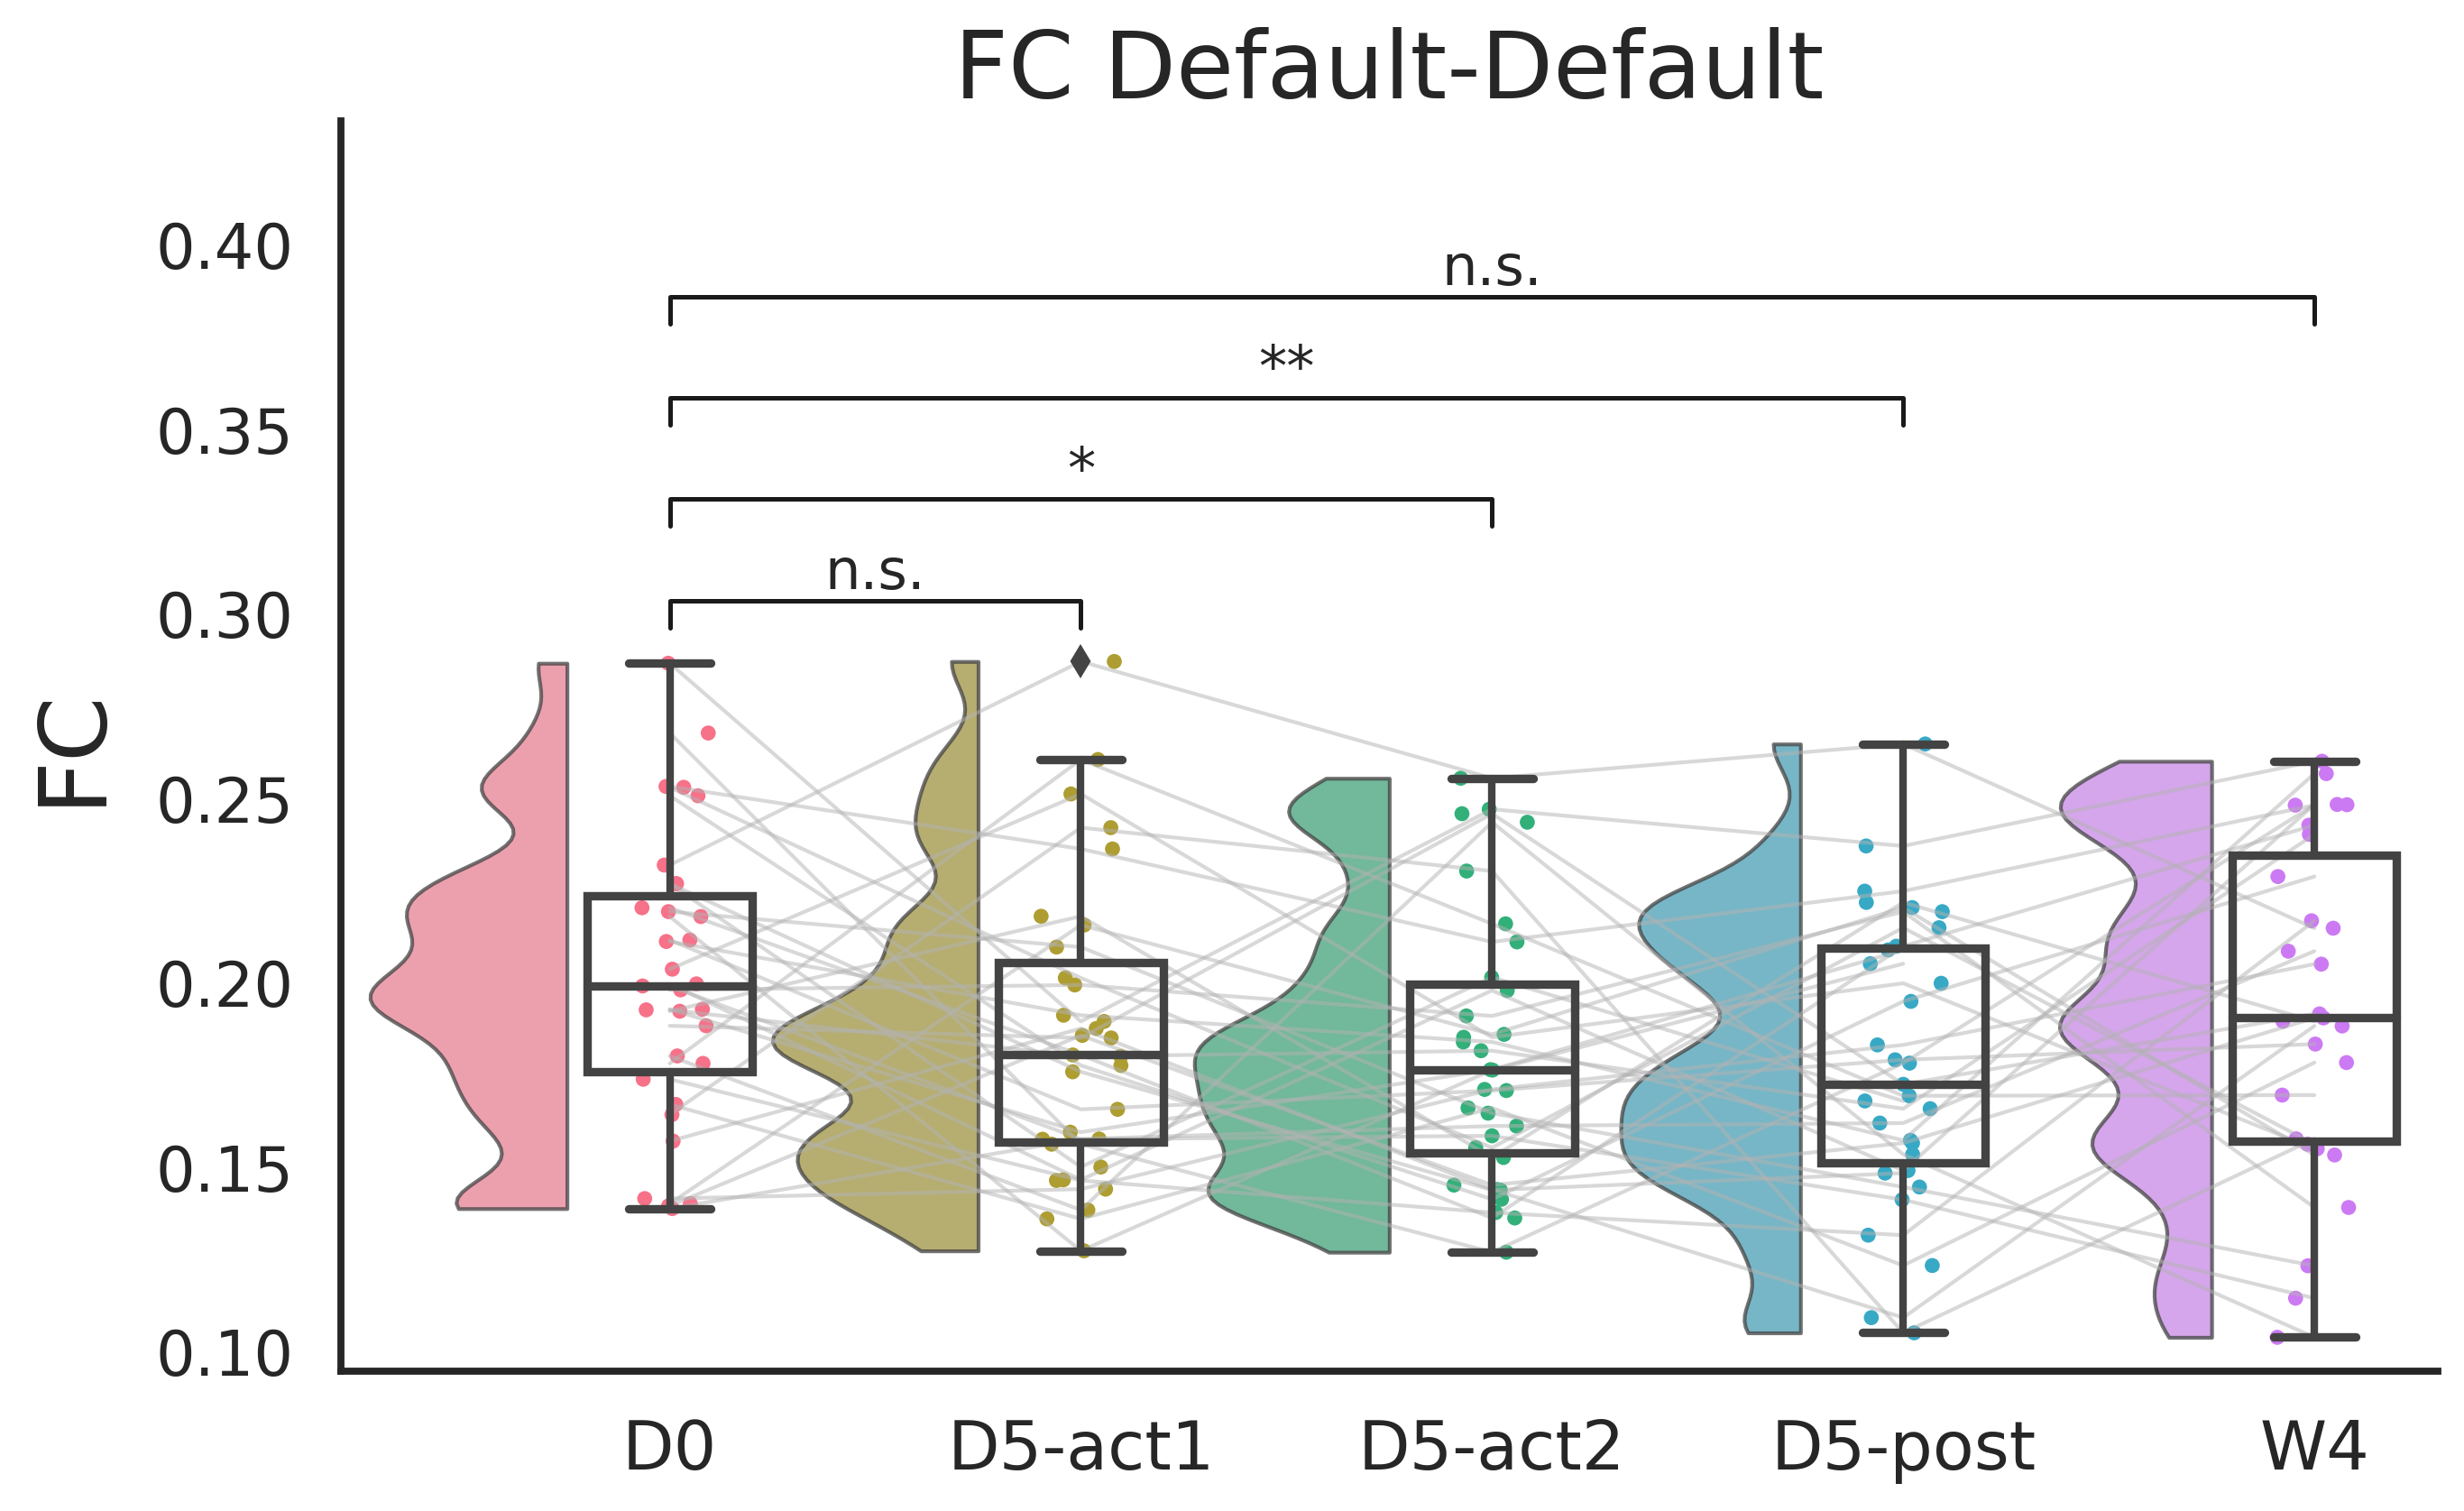

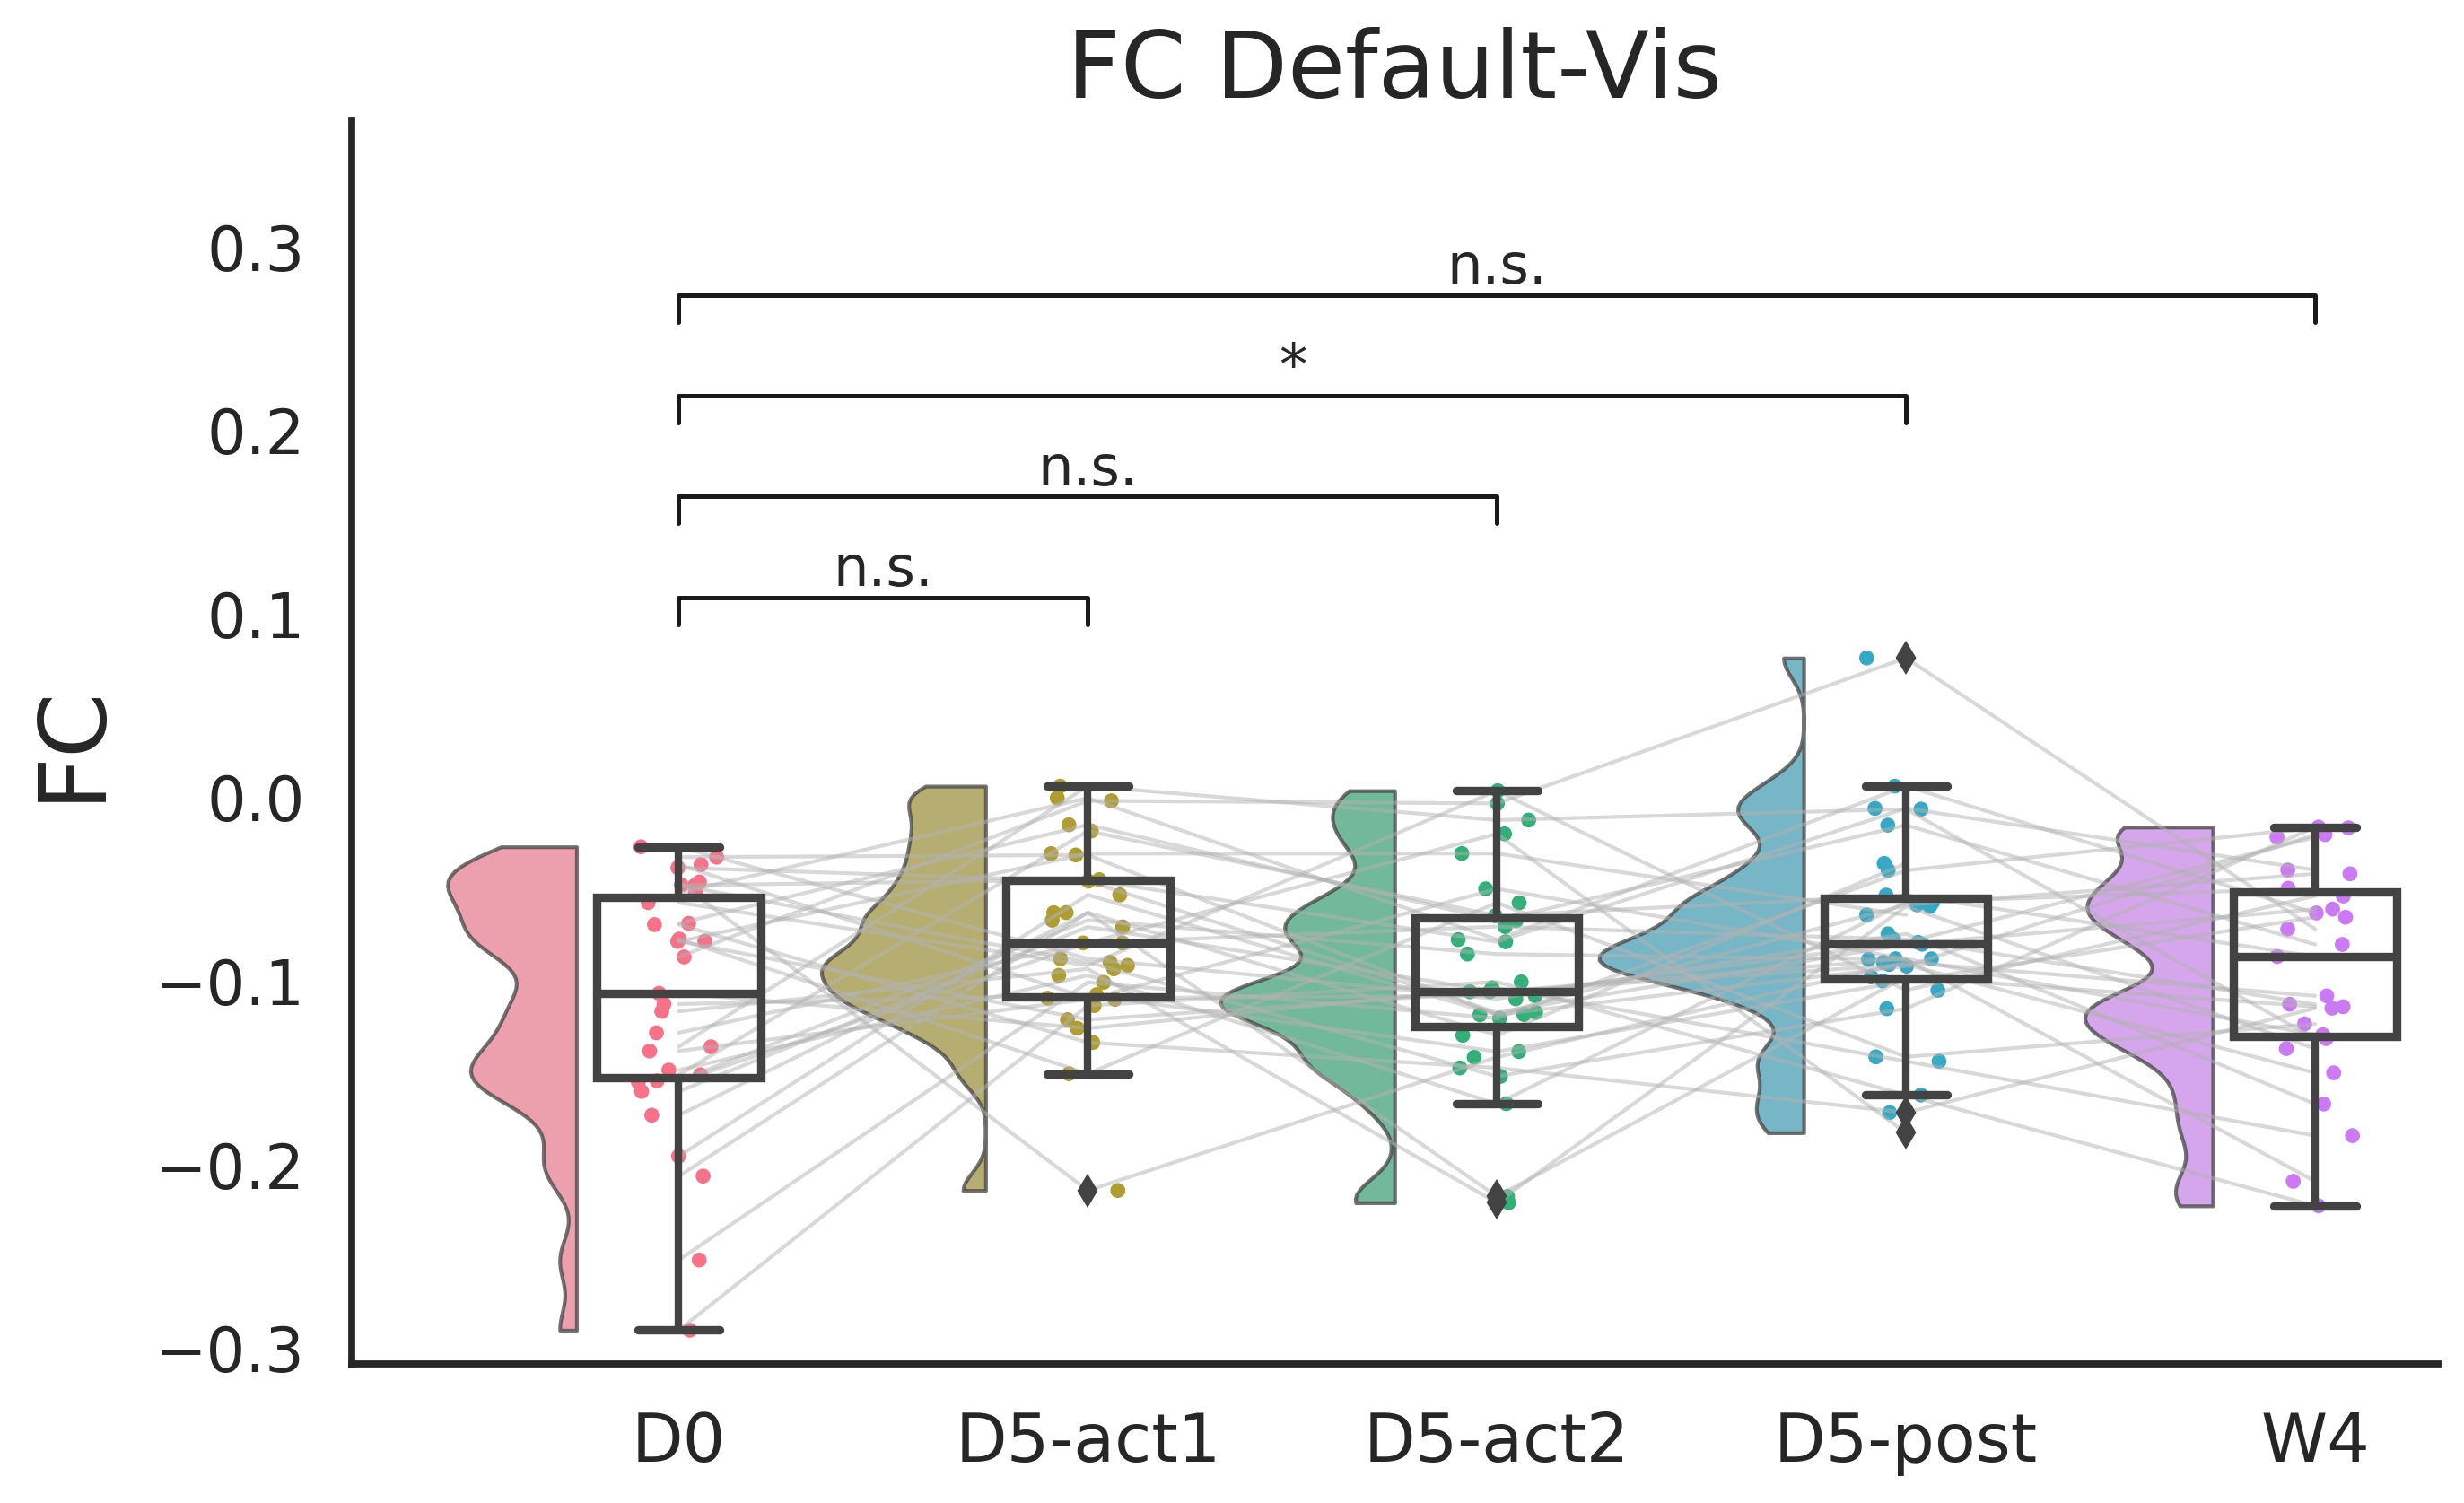

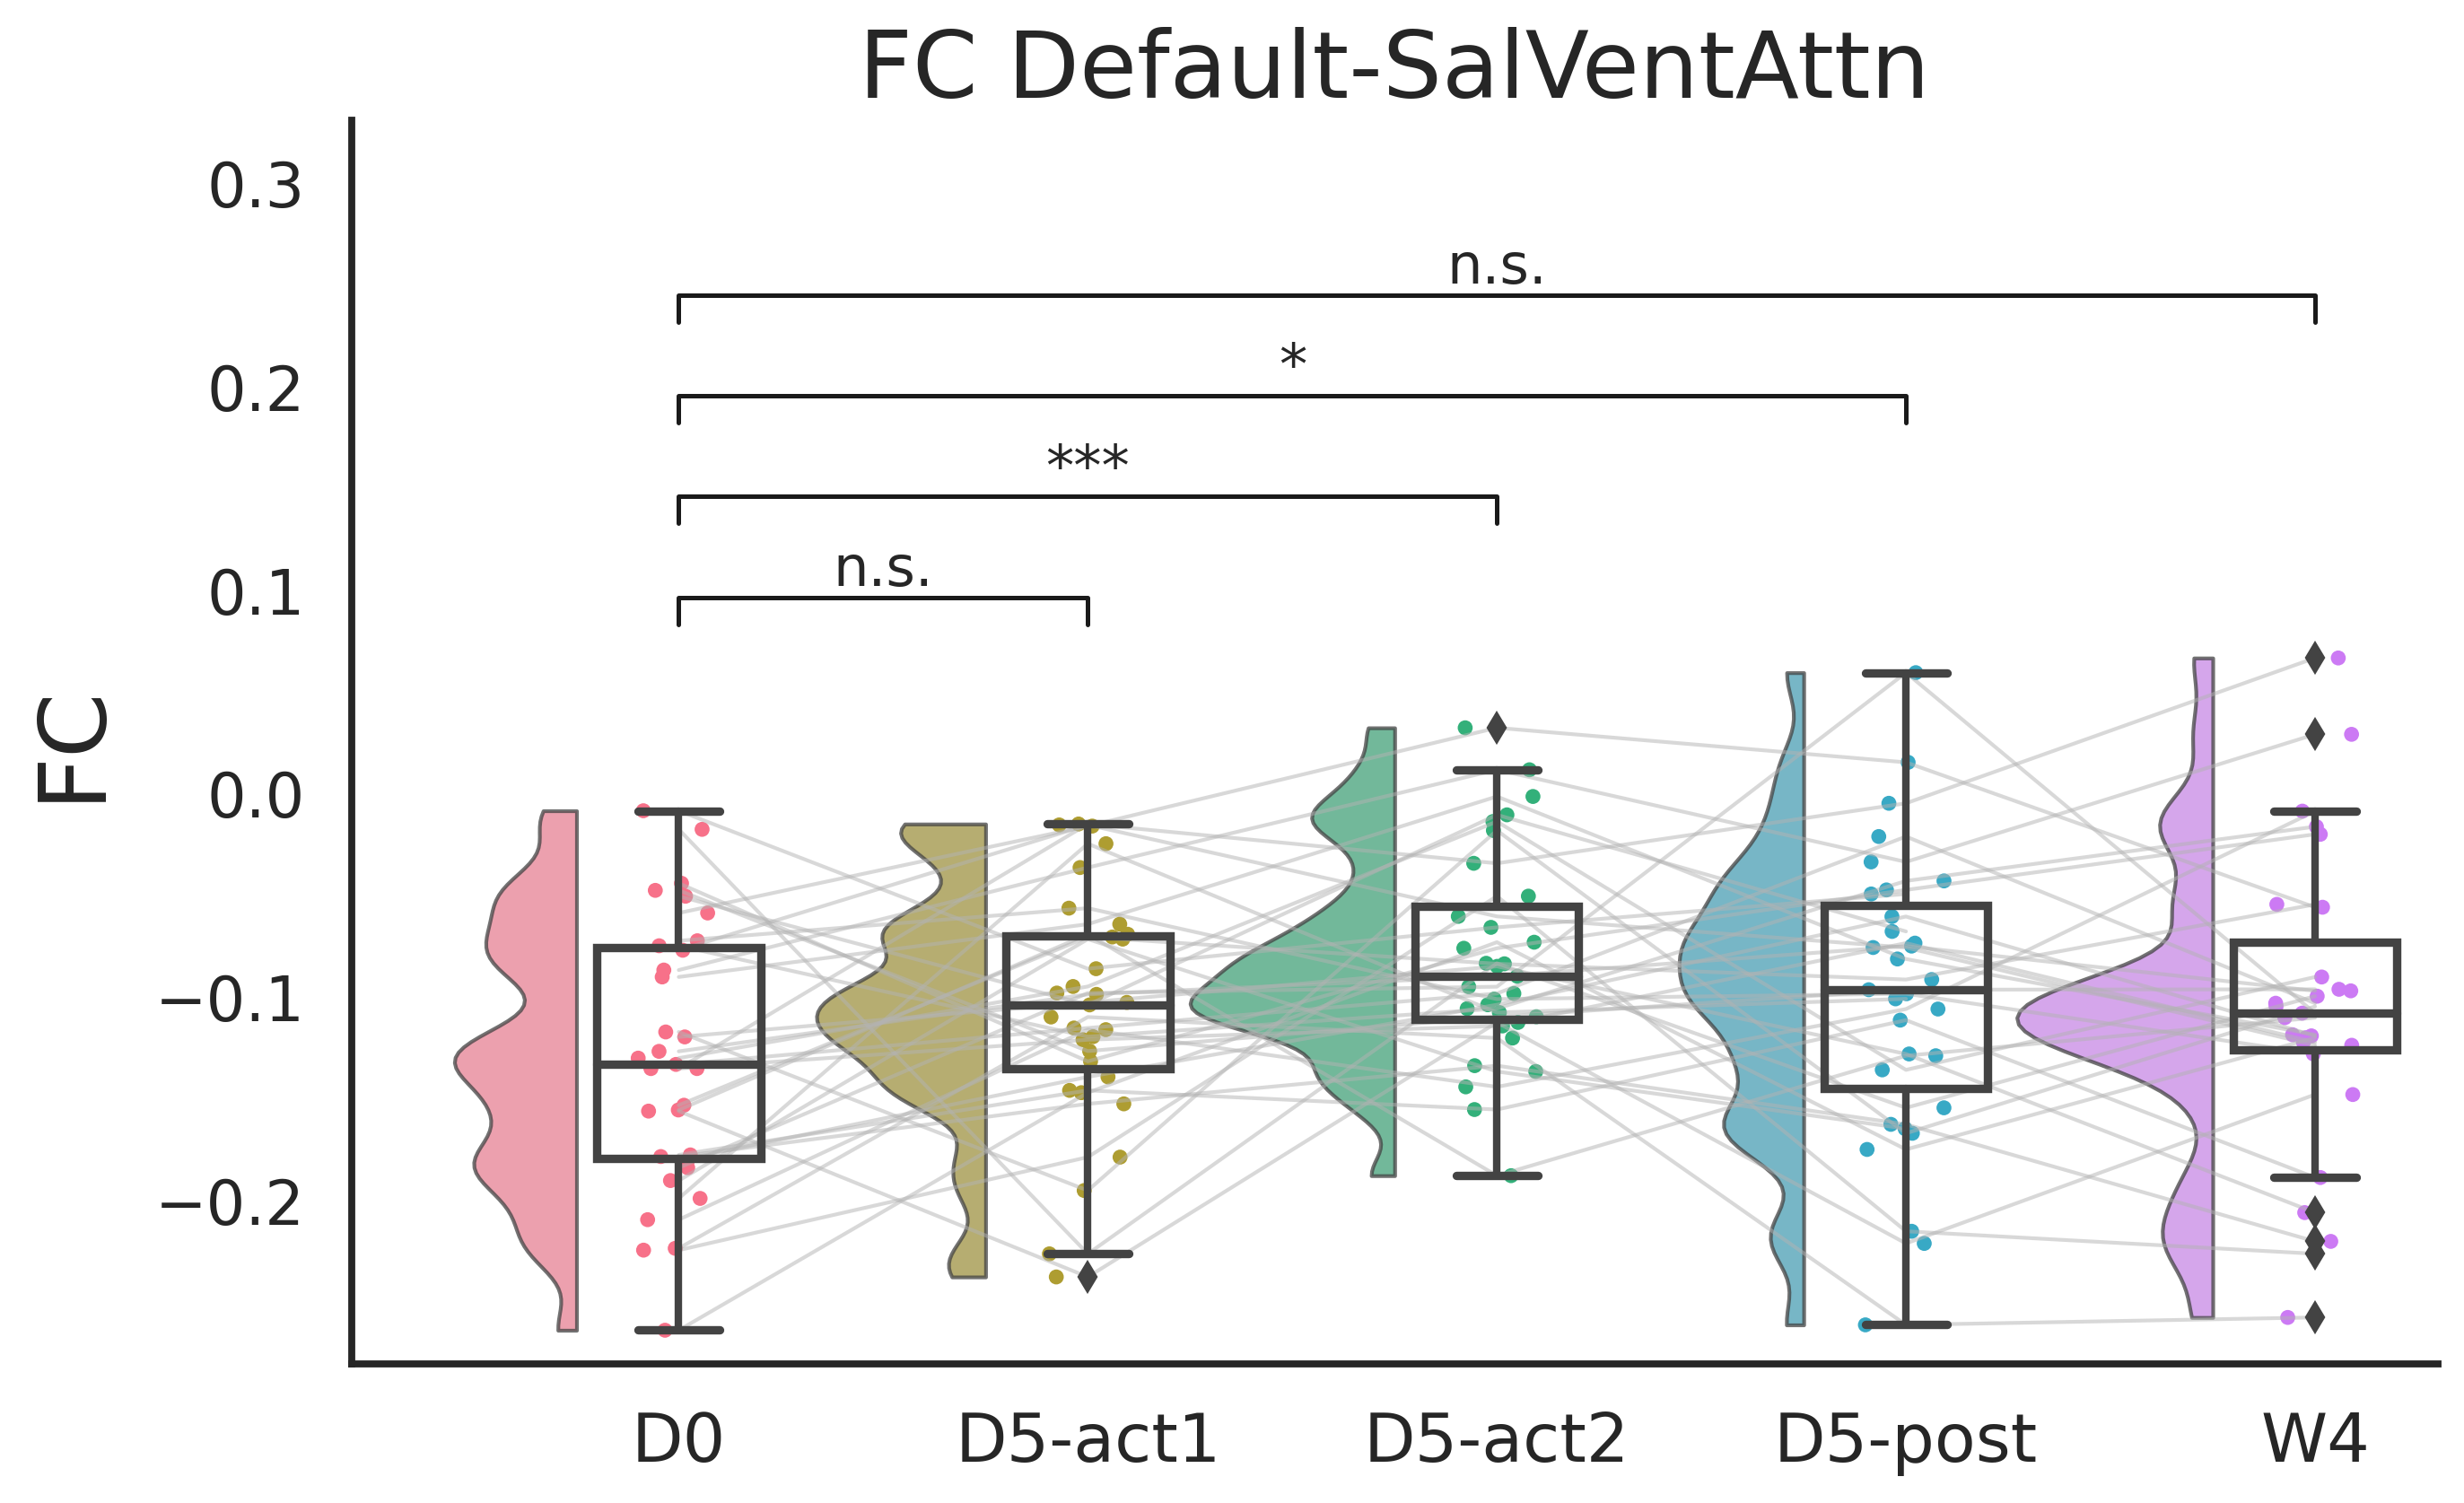

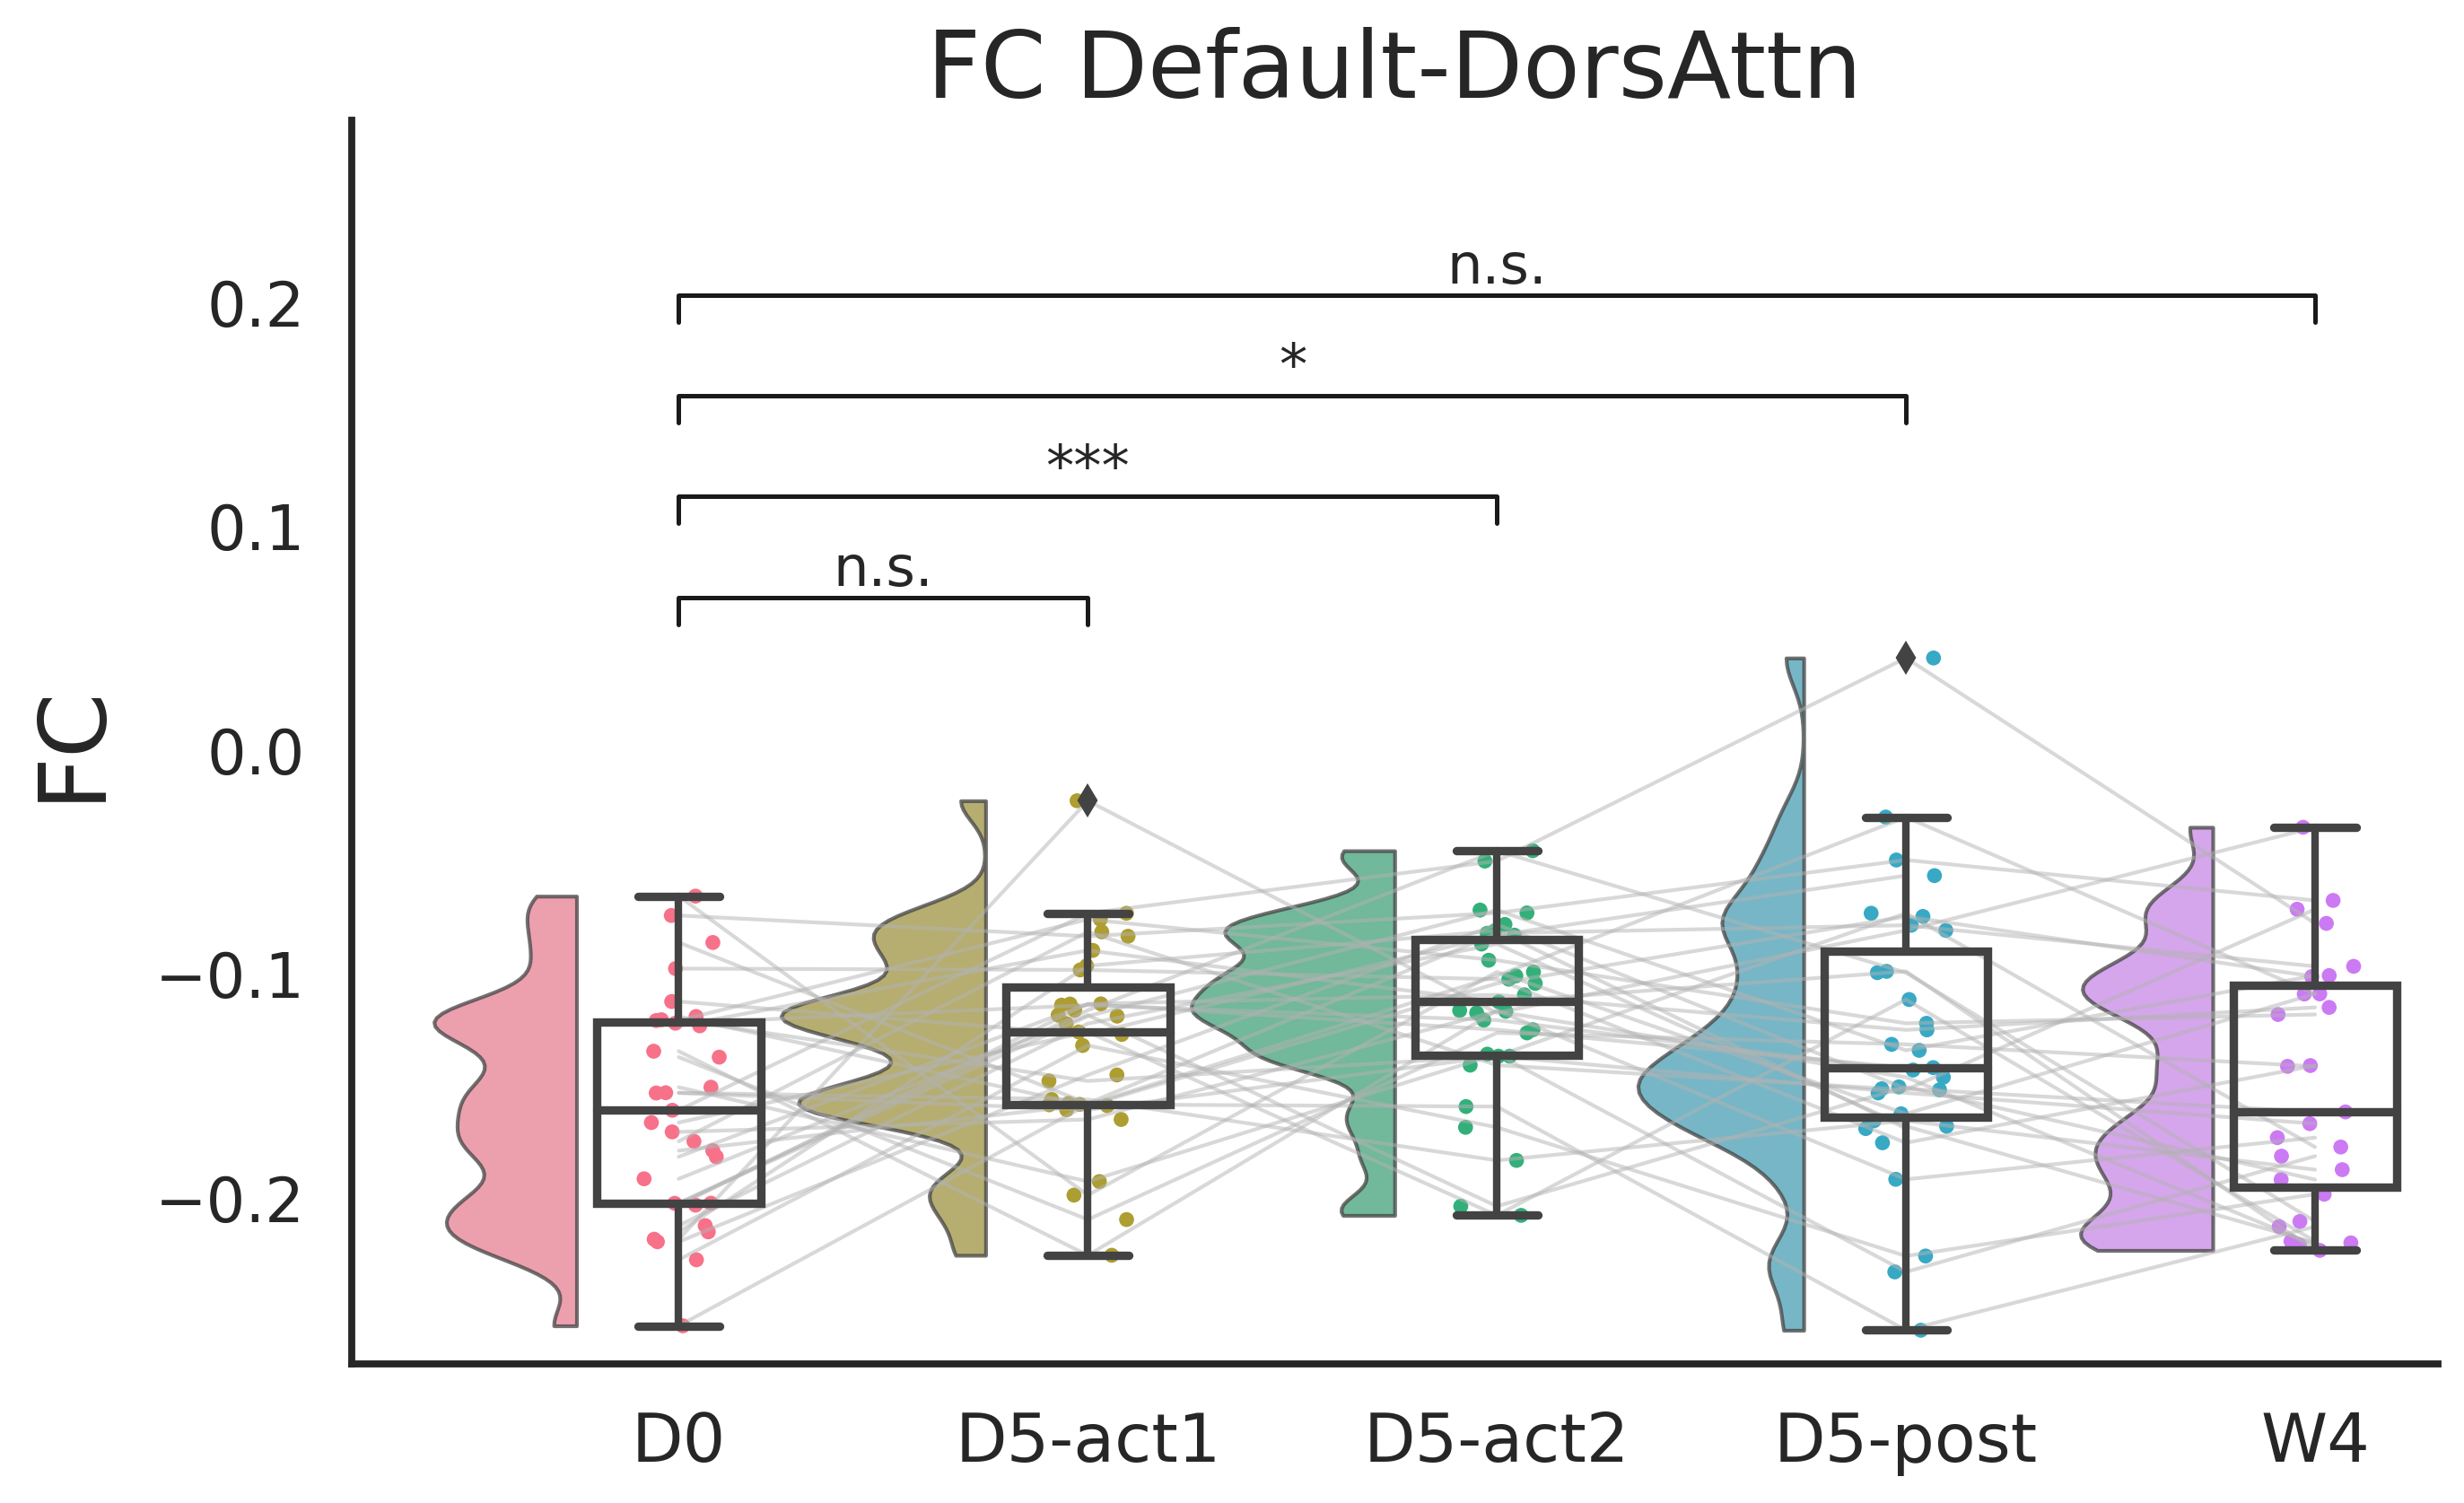

In [69]:
schaefer = '200'
title_schaefer = f"Schaefer {schaefer}"
df = pd.read_csv(f"/data/dy/TIS_MDD/FC_change/Default_{schaefer}.csv")
df = df.drop_duplicates()
df = df[df['time']!='1st_201'];df = df[df['time']!='1st_301']
df = df.loc[:,['FC','time','sub_id','sex_id','age','rsn_y']]
df.columns = ['FC','condition','sub','sex_id','age','rsn']
df = df[df['condition']!='1st_201']
df = df[df['condition']!='1st_301']

rsn = 'Default'
df_rsn = df[df['rsn'] == rsn]
longitudinal_plot(df_rsn,value_col='FC',value_label = f"FC",
                  time_order = ['baseline','5th_201','5th_301','5th_after','4weeks'],
                  display_labels = ['D0','D5-act1','D5-act2','D5-post','W4'],
                  p_values = np.array(ps[ps['index']==rsn]['q'].tolist()),
                    title=f"FC Default-{rsn}")

rsn = 'Vis'
df_rsn = df[df['rsn'] == rsn]
longitudinal_plot(df_rsn,value_col='FC',value_label = f"FC",
                  time_order = ['baseline','5th_201','5th_301','5th_after','4weeks'],
                  display_labels = ['D0','D5-act1','D5-act2','D5-post','W4'],
                  p_values = np.array(ps[ps['index']==rsn]['q'].tolist()),
                    title=f"FC Default-{rsn}")

rsn = 'SalVentAttn'
df_rsn = df[df['rsn'] == rsn]
longitudinal_plot(df_rsn,value_col='FC',value_label = f"FC",
                  time_order = ['baseline','5th_201','5th_301','5th_after','4weeks'],
                  display_labels = ['D0','D5-act1','D5-act2','D5-post','W4'],
                  p_values = np.array(ps[ps['index']==rsn]['q'].tolist()),
                    title=f"FC Default-{rsn}")

rsn = 'DorsAttn'
df_rsn = df[df['rsn'] == rsn]
longitudinal_plot(df_rsn,value_col='FC',value_label = f"FC",
                  time_order = ['baseline','5th_201','5th_301','5th_after','4weeks'],
                  display_labels = ['D0','D5-act1','D5-act2','D5-post','W4'],
                  p_values = np.array(ps[ps['index']==rsn]['q'].tolist()),
                    title=f"FC Default-{rsn}")